# This notebook shows examples of FAST-PT functionality

Notebook by: Jonathan Blazek (blazek@berkeley.edu)  
FAST-PT on github: https://github.com/JoeMcEwen/FAST-PT  
Easy fast-pt installation:
* pip install fast-pt
* conda install fast-pt

(Note, use `--no-deps` with pip if you use `conda` for most python packages)  
Examples available from `examples/` on github

<h2> Quick overview:</h2>  

<b> Step 0:</b> Install fast-pt.  

<b> Step 1:</b> Get (k,Plin) with even log sampling.  

<b> Step 2:</b> Initialize a fast-pt object: fpt_obj = fpt.FASTPT(k, to_do=to_do, ...)  

<b> Step 3:</b> Calculated desired PT quantities: *e.g.*, P_spt = fpt_obj.one_loop_dd(Plin)  

<b> Step 4:</b> Assemble into final quantity: *e.g.*, P_1loop = Plin + P_spt[0]


In [1]:
# import standard packages
import numpy as np
import pylab as plt
%matplotlib inline

# import fastpt
import fastpt as fpt
import fastpt.HT as HT

# import the Core Cosmology Library (CCL) if you have it
try:
    import pyccl as ccl
    have_ccl = True
except:
    have_ccl = False
    print('CCL not found. Steps with CCL will be skipped.')

# If you want to test HT against external Bessel transform code, e.g. mcfit
try:
    from mcfit import P2xi
    have_mcfit = True
except:
    have_mcfit = False
    print('mcfit not found. Steps with mcfit will be skipped.')

<h3> Get $P_{\rm lin}(k)$ from an external source: </h3>

In [2]:
## Get from CCL (which runs CLASS by default)
if have_ccl:
    # set two cosmologies
    cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
    cosmo2 = ccl.Cosmology(Omega_c=0.30, Omega_b=0.045, h=0.67, A_s=2.0e-9, n_s=0.96)

    # Get the linear power spectrum at z=0 for our given cosmologies
    # k array to be used for power spectra
    nk = 512
    log10kmin = -5
    log10kmax = 2
    ks = np.logspace(log10kmin,log10kmax,nk)
    pk_lin_z0 = ccl.linear_matter_power(cosmo,ks,1)
    pk_lin_z0_2 = ccl.linear_matter_power(cosmo2,ks,1)

## Or get from pre-computed CAMB run
# This file is in the same examples/ folder
d = np.loadtxt('Pk_test.dat')
k = d[:, 0]
pk = d[:, 1]
p22 = d[:, 2]
p13 = d[:, 3]

if not have_ccl:
    ks = k
    pk_lin_z0 = pk
    pk_lin_z0_2 = None
    
## Or get from your preferred Boltzmann code

# Note: k needs to be evenly log spaced. FAST-PT will raise an error if it's not.
# We have an issue to add automatic interpolation, but this is not yet implemented.

# Evaluation time scales as roughly N*logN. Tradeoff between time and accuracy in choosing k resolution.
# Currently, k sampling must be done outside of FAST-PT. This feature will also be added.

In [3]:
# Set FAST-PT settings.

# the to_do list sets the k-grid quantities needed in initialization (e.g. the relevant gamma functions)
to_do = ['one_loop_dd', 'dd_bias', 'one_loop_cleft_dd', 'IA_all', 'OV', 'kPol', 'RSD', 'IRres']

pad_factor = 1 # padding the edges with zeros before Pk repeats
n_pad = pad_factor*len(ks)
low_extrap = -5 # Extend Plin to this log10 value if necessary (power law)
high_extrap = 3 # Extend Plin to this log10 value if necessary (power law)
P_window = None # Smooth the input power spectrum edges (typically not needed, especially with zero padding)
C_window = .75 # Smooth the Fourier coefficients of Plin to remove high-frequency noise.

<h3> Initialize a FAST-PT object on a given k-grid. </h3>
<h3> This step does not depend on cosmology and can be re-used, e.g. in an MCMC. </h3>
<h4> (CosmoSIS has this implemented, saving roughly 50% of total FAST-PT runtime.) </h4>

In [4]:
# FAST-PT will parse the full to-do list and only calculate each needed quantity once.
# Ideally, the initialization happens once per likelihood evaluation, or even once per chain.

fpt_obj = fpt.FASTPT(ks,to_do=to_do,low_extrap=low_extrap,high_extrap=high_extrap,n_pad=n_pad)

#fpt_obj_temp = fpt.FASTPT(k,to_do=to_do,low_extrap=low_extrap,high_extrap=high_extrap,n_pad=n_pad)

<h3> Now we start calculating things that depend on cosmology </h3>

In [5]:
# For PT, we need to multiply by the relevant powers of the growth factor.
# For simplicity, we will do this all at z=0, where growth = 1. But we will keep the factors explicit.
growth = 1.0
g2 = growth**2
g4 = growth**4

## If you have CCL, you could use that here for growth at any redshift.
if have_ccl:
    z = 0.0
    gz = ccl.growth_factor(cosmo,1./(1+z))
    g2 = gz**2
    g4 = gz**4

<h3>Simplest case: 1-loop SPT for matter.</h3>  
$\delta_m = \delta^{(1)} + \delta^{(2)} + \delta^{(3)} + \cdots$  
$P_{mm} = P_{11} + P_{22} + 2P_{13} + \cdots$

In [6]:
# Calculate the 1-loop contributions with fast-pt
P_spt = fpt_obj.one_loop_dd(pk_lin_z0,C_window=C_window,P_window=P_window)[0]

# Assemble the 1-loop Pk:
P_1loop = g2*pk_lin_z0 + g4*P_spt

if have_ccl:
    # If you have a second cosmology, can run it here.
    # Both cosmologies use the same fast-pt object.
    P_spt_2 = fpt_obj.one_loop_dd(pk_lin_z0_2,C_window=C_window,P_window=P_window)[0]
    P_1loop_2 = g2*pk_lin_z0_2 + g4*P_spt_2

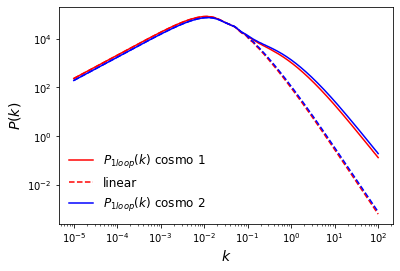

In [7]:
# Plot
plt.plot(ks,P_1loop, 'r', label='$P_{1loop}(k)$ cosmo 1')
plt.plot(ks,pk_lin_z0, 'r--', label='linear')
if have_ccl:
    plt.plot(ks,P_1loop_2, 'b', label='$P_{1loop}(k)$ cosmo 2')
    plt.plot(ks,pk_lin_z0_2, 'b--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$P(k)$', fontsize=14)
plt.legend(loc='lower left', fontsize=12, frameon=False)

<h3> FAST-PT includes an implementation of FFTLog for Bessel transforms. </h3>

/Users/blazek/Packages/anaconda3/envs/ccl/lib/python3.6/site-packages/mcfit/mcfit.py:125: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/Users/blazek/Packages/anaconda3/envs/ccl/lib/python3.6/site-packages/mcfit/mcfit.py:219: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


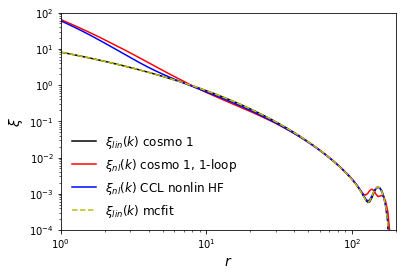

In [8]:
# Calculate the standard correlation function
r,xi = HT.k_to_r(ks,pk_lin_z0,1.5,-1.5,.5, (2.*np.pi)**(-1.5))
r,xi_1loop = HT.k_to_r(ks,P_1loop,1.5,-1.5,.5, (2.*np.pi)**(-1.5))
#r2,xi2 = HT2.k_to_r(ks,pk_lin_z0,1.5,-1.5,.5, (2.*np.pi)**(-1.5))
# For the J2 transform (e.g. DeltaSigma or w_g+)
# r,xi_2=HT.k_to_r(k,P,1.,-1.,2., 4.*np.pi*np.sqrt(np.pi/2.))

if have_mcfit:
    # can test the transform with other code, e.g. mcfit
    rr,xxi = P2xi(ks)(pk_lin_z0)
if have_ccl:
    # can also compare to the output from CCL
    kmin, kmax, nk = 1e-4, 1e1, 128
    rmin, rmax, nr = 1, 2e2, 128
    kccl = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
    rccl = np.logspace(np.log10(rmin), np.log10(rmax), nr)
    a = 1. # Scale factor a z=0
    xi_nl = ccl.correlation_3d(cosmo,a, rccl)

# Make a plot
plt.plot(r,xi, 'k', label=r'$\xi_{lin}(k)$ cosmo 1')
plt.plot(r,xi_1loop, 'r', label=r'$\xi_{nl}(k)$ cosmo 1, 1-loop')
#plt.plot(r2,xi2, 'b', label=r'$\xi_{lin}(k)$ cosmo 1, new HT')
if have_ccl:
    plt.plot(rccl,xi_nl, 'b', label=r'$\xi_{nl}(k)$ CCL nonlin HF')
if have_mcfit:
    plt.plot(rr ,xxi, 'y--', label=r'$\xi_{lin}(k)$ mcfit')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$\xi$', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e-4,1e2)
plt.legend(loc='lower left', fontsize=12, frameon=False)

<b> As has been well-documented, SPT does not properly handle bulk velocities, leading to a poor description of the BAO.</b>

<h3>IR-resummation techniques can fix this. FAST-PT includes an implementation from M. Ivanov.</h3>

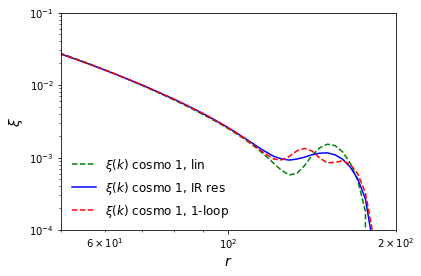

In [9]:
P_IRres = fpt_obj.IRres(pk_lin_z0,C_window=C_window)
# Note that this function needs documentation/validation

r,xi_IRres = HT.k_to_r(ks,P_IRres,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

# Plot
plt.plot(r,xi, 'g--', label=r'$\xi(k)$ cosmo 1, lin')
plt.plot(r,xi_IRres, 'b', label=r'$\xi(k)$ cosmo 1, IR res')
plt.plot(r,xi_1loop, 'r--', label=r'$\xi(k)$ cosmo 1, 1-loop')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$\xi$', fontsize=14)
if have_ccl:
    plt.xlim(5e1,2e2)
else:
    plt.xlim(3e1,1.5e2)
plt.ylim(1e-4,1e-1)
plt.legend(loc='lower left', fontsize=12, frameon=False)


<h3> Eulerian biasing.</h3>  
$\delta_g = b_1 \delta_m + \frac{1}{2}b_2 \delta_m^2 + \frac{1}{2}b_s s^2 + \frac{1}{2}b_{3nl} \psi + \cdots$

In [10]:
P_bias_E = fpt_obj.one_loop_dd_bias_b3nl(pk_lin_z0,C_window=C_window)

# Output individual terms
Pd1d1 = g2 * pk_lin_z0 + g4 * P_bias_E[0] # could use halofit or emulator instead of 1-loop SPT
Pd1d2 = g4 * P_bias_E[2]
Pd2d2 = g4 * P_bias_E[3]
Pd1s2 = g4 * P_bias_E[4]
Pd2s2 = g4 * P_bias_E[5]
Ps2s2 = g4 * P_bias_E[6]
Pd1p3 = g4 * P_bias_E[8]
s4 =  g4 * P_bias_E[7] # sigma^4 which determines the (non-physical) low-k contributions

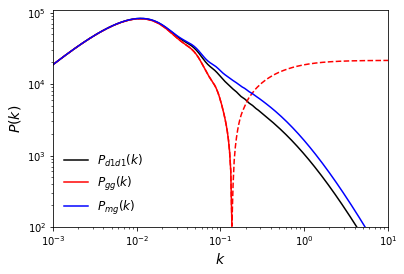

In [11]:
# set bias parameters
b11=b12=1.0
b21=b22=1.0
bs1=bs2=1.0
b3nl1=b3nl2=1.0

# Combine for P_gg or P_mg
P_gg = ((b11*b12) * Pd1d1 +
        0.5*(b11*b22 + b12*b21) * Pd1d2 +
        0.25*(b21*b22) * (Pd2d2 - 2.*s4) +
        0.5*(b11*bs2 + b12*bs1) * Pd1s2 +
        0.25*(b21*bs2 + b22*bs1) * (Pd2s2 - (4./3.)*s4) +
        0.25*(bs1*bs2) * (Ps2s2 - (8./9.)*s4) +
        0.5*(b11 * b3nl2 + b12 * b3nl1) * Pd1p3)

P_mg = (b11 * Pd1d1 +
        0.5*b21 * Pd1d2 +
        0.5*bs1 * Pd1s2 +
        0.5*b3nl1 * Pd1p3)

# Plot
plt.plot(ks,Pd1d1, 'k', label='$P_{d1d1}(k)$')
plt.plot(ks,P_gg, 'r', label='$P_{gg}(k)$')
plt.plot(ks,abs(P_gg), 'r--')
plt.plot(ks,P_mg, 'b', label='$P_{mg}(k)$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$P(k)$', fontsize=14)
plt.xlim(1e-3,1e1)
plt.ylim(1e2,1.1e5)
plt.legend(loc='lower left', fontsize=12, frameon=False)

<h3> Lagrangian biasing.</h3>  
e.g. Matsubara 2013.

In [12]:
P_bias_L = fpt_obj.one_loop_dd_bias_lpt_NL(pk_lin_z0,C_window=C_window)
# Full example coming

<h3> Intrinsic alignments.</h3>
e.g. "TATT" model, Blazek et al 2019:  
  
$\gamma^{\rm IA}_{ij} = C_1 s_{ij} + C_2 s_{ik}s_{kj} + C_{1\delta} \delta s_{ij} + C_t t_{ij} + \cdots$  
(Note: $t_{ij}$ term not yet released or merged into master.)

In [13]:
P_IA_tt=fpt_obj.IA_tt(pk_lin_z0,C_window=C_window)
P_IA_ta=fpt_obj.IA_ta(pk_lin_z0,C_window=C_window)
P_IA_mix=fpt_obj.IA_mix(pk_lin_z0,C_window=C_window)
# Full example coming.
# See CCLX repo for example with CCL.

<h3> Convolutional Lagrangian Effective Field Theory (CLEFT).</h3>  

In [14]:
# P_CLEFT = fpt_obj.cleft_Q_R(pk_lin_z0,C_window=C_window)
# Currently broken. Work in progress.
# Full example coming

<h3> Redshift-space distortions with the TNS model.</h3>  
<b> $A(k), B(k)$ implemented.  
    Note: 1-1loop contributions currently being added for $P_{\theta\theta}, P_{\delta\theta}$ .</b>

In [15]:
P_RSD=fpt_obj.RSD_components(pk_lin_z0,1.0,C_window=C_window)
# Full example coming
# Will re-factor output to allow more efficient dependence on f

<h2> CCL has built-in FAST-PT capabilities - see notebooks in CCLX repo. FAST-PT is also integrated in CosmoSIS and CosmoLike. </h2>

In [16]:
P_tidal=fpt_obj.IA_tidal(pk_lin_z0,1.0,C_window=C_window)

AttributeError: 'FASTPT' object has no attribute 'IA_tidal'